In [4]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 13.8 MB/s eta 0:00:00:00:010:01m

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 9.1 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from numpy import mean
from numpy import std
import string
import math

In [6]:
casas = pd.read_csv("kc_house_data.csv")

casas.drop(['id'],axis=1,inplace=True)
casas.drop(['date'],axis=1,inplace=True)

In [ ]:
# O TRECHO COMENTADO ABAIXO NÃO MELHOROU OS RESULTADOS

# Aplicando o OneHotEncoder de forma mais simples
#casas = pd.get_dummies(casas, columns=['zipcode'], prefix='zipcode')

In [7]:
multiplicador = 0.01

def identificar_outliers(coluna):
    Q1 = coluna.quantile(0.25)
    Q3 = coluna.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - multiplicador * IQR
    limite_superior = Q3 + multiplicador * IQR
    outliers = coluna[(coluna < limite_inferior) | (coluna > limite_superior)]
    return outliers

for coluna in casas.columns:
    if pd.api.types.is_numeric_dtype(casas[coluna]):
        outliers = identificar_outliers(casas[coluna])

        if not outliers.empty:
            print(f"Outliers na coluna {coluna}:\n{outliers}\n")

Outliers na coluna price:
0         221900.0
2         180000.0
5        1225000.0
6         257500.0
7         291850.0
           ...    
21597    1575000.0
21599     810000.0
21600    1537000.0
21602     224000.0
21606    1007500.0
Name: price, Length: 10583, dtype: float64

Outliers na coluna bedrooms:
2        2
11       2
14       5
18       2
22       5
        ..
21595    2
21596    5
21600    5
21610    2
21612    2
Name: bedrooms, Length: 4907, dtype: int64

Outliers na coluna bathrooms:
0        1.00
2        1.00
3        3.00
5        4.50
7        1.50
         ... 
21599    3.00
21600    3.75
21606    3.50
21610    0.75
21612    0.75
Name: bathrooms, Length: 9208, dtype: float64

Outliers na coluna sqft_living:
0        1180
1        2570
2         770
5        5420
7        1060
         ... 
21600    4470
21606    3510
21607    1310
21610    1020
21612    1020
Name: sqft_living, Length: 10608, dtype: int64

Outliers na coluna sqft_lot:
5        101930
12        19901
1

In [8]:
# Colunas que irá passar por ajustes de outliers (0 - não, 1 - sim)
colunas_avaliadas = {
    'price': 0,
    'bedrooms': 1,
    'bathrooms': 1,
    'sqft_living': 1,
    'sqft_lot': 1,
    'floors': 1,
    'waterfront': 0,
    'view': 0,
    'condition': 0,
    'grade': 0,
    'sqft_above': 1,
    'sqft_basement': 1,
    'yr_built': 0,
    'yr_renovated': 0,
    'zipcode': 0,
    'lat': 0,
    'long': 0,
    'sqft_living15': 1,
    'sqft_lot15': 1
}

multiplicador = 0.01 # Comecei em 1.5 e fui diminuindo, quanto menor o valor mais lento é para ajustar os outliers, no entanto, melhora o resultado.
qtd = 0

for coluna in casas.columns:
    if pd.api.types.is_numeric_dtype(casas[coluna]) and colunas_avaliadas.get(coluna, 0):
        Q1 = casas[coluna].quantile(0.25)
        Q3 = casas[coluna].quantile(0.75)
        IQR = Q3 - Q1

        # Calcular os limites para identificação de outliers
        limite_inferior = Q1 - multiplicador * IQR
        limite_superior = Q3 + multiplicador * IQR

        outliers = (casas[coluna] < limite_inferior) | (casas[coluna] > limite_superior)

        for outlier in casas[coluna][outliers].index:
            preco_correspondente = casas.loc[outlier, 'price']

            # Considerar uma tolerância de 50 mil para mais ou para menos no preço correspondente
            preco_minimo = preco_correspondente - 50000
            preco_maximo = preco_correspondente + 50000

            valores_nao_outliers = casas[(casas['price'] >= preco_minimo) & (casas['price'] <= preco_maximo) & ~outliers][coluna]

            # Verificar se há valores não outliers para calcular a média
            if not valores_nao_outliers.empty:
                media_valor = valores_nao_outliers.mean()
                casas.loc[outlier, coluna] = int(media_valor)
            else:
                # Se não houver valores não outliers, incrementar a contagem
                #casas = casas.drop(outlier)
                qtd += 1

print(qtd)

518


# Na seção abaixo apliquei uma transformação logarítima em algumas features

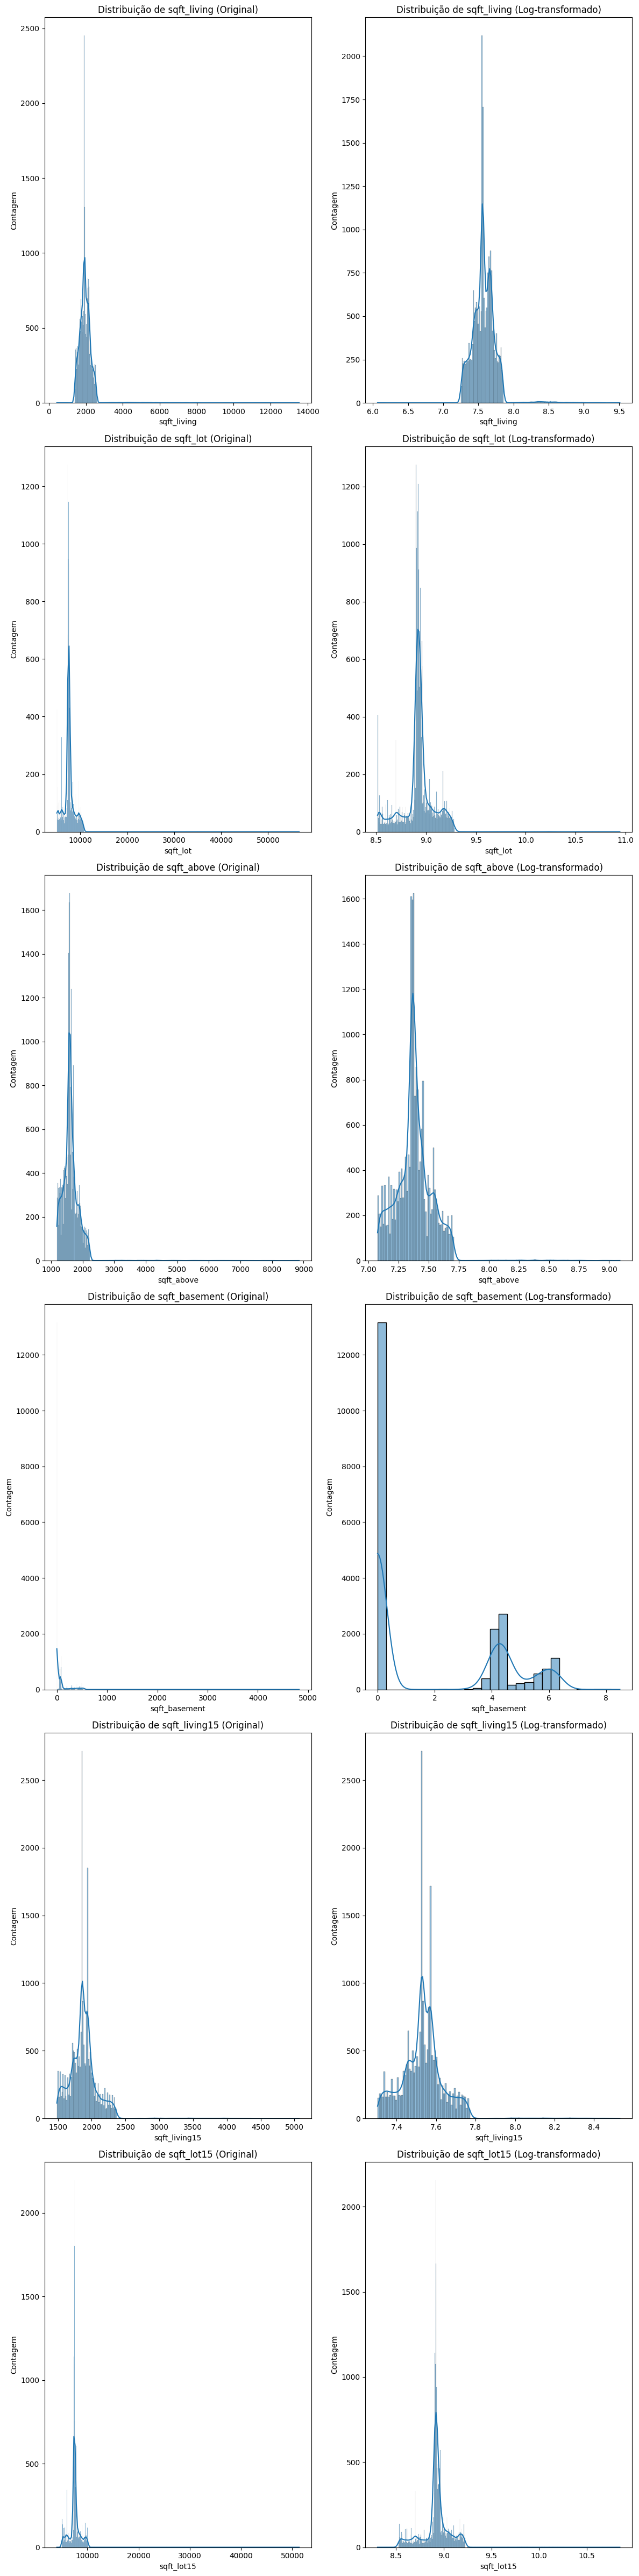

In [9]:
colunas_avaliadas = {
    'price': 0,
    'bedrooms': 0,
    'bathrooms': 0,
    'sqft_living': 1,
    'sqft_lot': 1,
    'floors': 0,
    'waterfront': 0,
    'view': 0,
    'condition': 0,
    'grade': 0,
    'sqft_above': 1,
    'sqft_basement': 1,
    'yr_built': 0,
    'yr_renovated': 0,
    'zipcode': 0,
    'lat': 0,
    'long': 0,
    'sqft_living15': 1,
    'sqft_lot15': 1
}

casas_log1p = casas.copy()

# Filtrando as colunas avaliadas
colunas_para_plotar = [coluna for coluna, avaliada in colunas_avaliadas.items() if avaliada == 1]

# Criando subplots
fig, axs = plt.subplots(len(colunas_para_plotar), 2, figsize=(12, 8*len(colunas_para_plotar)))

# Iterando sobre as colunas
for i, coluna in enumerate(colunas_para_plotar):
    # Plotando gráfico dos dados originais
    sns.histplot(casas[coluna], kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Distribuição de {coluna} (Original)')
    axs[i, 0].set_xlabel(coluna)
    axs[i, 0].set_ylabel('Contagem')

    # Aplicando a transformação logarítmica
    casas_log1p[coluna] = np.log1p(casas[coluna])

    # Plotando gráfico dos dados transformados
    sns.histplot(casas_log1p[coluna], kde=True, ax=axs[i, 1])
    axs[i, 1].set_title(f'Distribuição de {coluna} (Log-transformado)')
    axs[i, 1].set_xlabel(coluna)
    axs[i, 1].set_ylabel('Contagem')

# Ajustando o layout
plt.tight_layout()
plt.show()

casas = casas_log1p.copy()

In [10]:
imputer = KNNImputer(n_neighbors=5)
casas[['sqft_basement', 'yr_renovated']] = imputer.fit_transform(casas[['sqft_basement', 'yr_renovated']])

In [11]:
casas['view'] = casas['view'].apply(lambda x: 1 if x > 0 else 0)
casas['yr_renovated'] = casas['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
casas['waterfront'] = casas['waterfront'].apply(lambda x: 1 if x > 0 else 0)

# NÃO MELHOROU O RESULTADO, FEZ PIORAR
#casas['sqft_basement'] = casas['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)


In [ ]:
#A PARTE COMENTADA ABAIXO AUMENTOU O ERRO

#casas = casas.drop_duplicates()

#condition = (casas['sqft_living'] > casas['sqft_lot']) & (casas['floors'] == 1)
#for index, row in casas[condition].iterrows():
#    casas.at[index, 'sqft_living'] = row['sqft_living15']
#    casas.at[index, 'sqft_lot'] = row['sqft_lot15']

#condition = (casas['sqft_living15'] > casas['sqft_lot15']) & (casas['floors'] == 1)
#for index, row in casas[condition].iterrows():
#    casas.at[index, 'sqft_living15'] = row['sqft_living']
#    casas.at[index, 'sqft_lot15'] = row['sqft_lot']

#def classificar_regiao(lat, long, num_quadrantes):
#    # Define as coordenadas dos limites dos quadrantes
#    lat_limites = [47.1559 + i * ((47.7776 - 47.1559) / num_quadrantes) for i in range(num_quadrantes + 1)]
#    long_limites = [-122.519 + i * ((-121.315 - (-122.519)) / num_quadrantes) for i in range(num_quadrantes + 1)]

#    # Função para obter a letra do quadrante
#    def obter_letra(coordenadas, valor):
#        for i, limite in enumerate(coordenadas):
#            if valor < limite:
#                return string.ascii_uppercase[i]
#        return string.ascii_uppercase[-1]

    # Calcula as letras dos quadrantes para lat e long
#    lat_letra = obter_letra(lat_limites, lat)
#    long_letra = obter_letra(long_limites, long)

#    # Combina as letras para formar a região
#    regiao = f"{lat_letra}{long_letra}"

#    return regiao

# Número de quadrantes desejado
#num_quadrantes = 90
#num_quadrantes = int(math.sqrt(num_quadrantes))

# Aplica a função para criar uma nova coluna 'regiao'
#casas['regiao'] = casas.apply(lambda row: classificar_regiao(row['lat'], row['long'], num_quadrantes), axis=1)
#casas = pd.get_dummies(casas, columns=['regiao'], prefix='regiao')

#casas = casas.drop('lat', axis=1)
#casas = casas.drop('long', axis=1)

In [12]:
scaler = MinMaxScaler()

features = casas.drop("price", axis=1)
target = casas["price"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features.copy(), target.copy(), test_size=0.30, random_state=50)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = XGBRegressor(colsample_bytree=1, gamma=0.0, learning_rate=0.01, max_depth=8, min_child_weight=8, n_estimators=7200, reg_alpha=1, reg_lambda=1, subsample=0.1, seed=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'R^2 no conjunto de teste: {r2_test}')
print(f'R^2 no conjunto de treino: {r2_train}')

R^2 no conjunto de teste: 0.952166643516284
R^2 no conjunto de treino: 0.979529235940273


# A consistência do modelo XGBRegressor é evidenciada pela média e desvio padrão dos resultados obtidos abaixo, indicando que o desempenho permanece estável mesmo diante de variações (0.25 até 0.35) na divisão do conjunto em teste e treino.

In [14]:
resultados = []
for size in np.arange(0.25, 0.36, 0.01):
  X_train, X_test, y_train, y_test = train_test_split(features.copy(), target.copy(), test_size=size, random_state=50)

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  model = XGBRegressor(colsample_bytree=1, gamma=0.0, learning_rate=0.01, max_depth=8, min_child_weight=8, n_estimators=7200, reg_alpha=1, reg_lambda=1, subsample=0.1, seed=42)
  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  r2_train = r2_score(y_train, y_train_pred)
  r2_test = r2_score(y_test, y_test_pred)

  print(f'R^2 no conjunto de teste: {r2_test}')
  print(f'R^2 no conjunto de treino: {r2_train}\n')
  resultados.append((size, r2_test, r2_train))

R^2 no conjunto de teste: 0.953281749004823
R^2 no conjunto de treino: 0.9796406543334558

R^2 no conjunto de teste: 0.9523762053732503
R^2 no conjunto de treino: 0.9796892726491583

R^2 no conjunto de teste: 0.9539428131813902
R^2 no conjunto de treino: 0.9796433503463515

R^2 no conjunto de teste: 0.9530316352850718
R^2 no conjunto de treino: 0.9797147735095166

R^2 no conjunto de teste: 0.9536644871621782
R^2 no conjunto de treino: 0.9797967216186446

R^2 no conjunto de teste: 0.952166643516284
R^2 no conjunto de treino: 0.979529235940273

R^2 no conjunto de teste: 0.952214799929282
R^2 no conjunto de treino: 0.979021747106803

R^2 no conjunto de teste: 0.9518636033979033
R^2 no conjunto de treino: 0.9793263158169218

R^2 no conjunto de teste: 0.9524320275710073
R^2 no conjunto de treino: 0.9790954670395574

R^2 no conjunto de teste: 0.9531434821687899
R^2 no conjunto de treino: 0.9793784701325681

R^2 no conjunto de teste: 0.9520794719078642
R^2 no conjunto de treino: 0.97926626245

In [15]:
# Cálculo da média e do desvio padrão para o item 2 (R^2 no conjunto de teste)
media_r2_test, desvio_padrao_r2_test = np.mean([item[1] for item in resultados]), np.std([item[1] for item in resultados])

# Cálculo da média e do desvio padrão para o item 3 (R^2 no conjunto de treino)
media_r2_train, desvio_padrao_r2_train = np.mean([item[2] for item in resultados]), np.std([item[2] for item in resultados])

# Imprimindo os resultados
print(f'Conjunto de teste\n\tMédia: {media_r2_test}\n\tDesvio padrão: {desvio_padrao_r2_test}\n')
print(f'Conjunto de treino\n\tMédia: {media_r2_train}\n\tDesvio padrão: {desvio_padrao_r2_train}')



Conjunto de teste
	Média: 0.9527451744088947
	Desvio padrão: 0.0006659659567380185

Conjunto de treino
	Média: 0.9794638428135116
	Desvio padrão: 0.00025022610592536905


Aplicando Cross Validation utilizando 5 split 
Este código irá plotar os valores reais e previstos para cada fold tanto para o conjunto de treinamento quanto para o conjunto de teste. As linhas azuis representam os valores reais e as linhas vermelhas representam os valores previstos pelo modelo. 

Cross_val_score no conjunto de treino para o Fold 1: [0.92760862 0.94092192 0.9548852  0.94600877 0.96276769]
Cross_val_score no conjunto de teste para o Fold 1: [0.94063734 0.92985521 0.9333837  0.93422056 0.9167661 ]



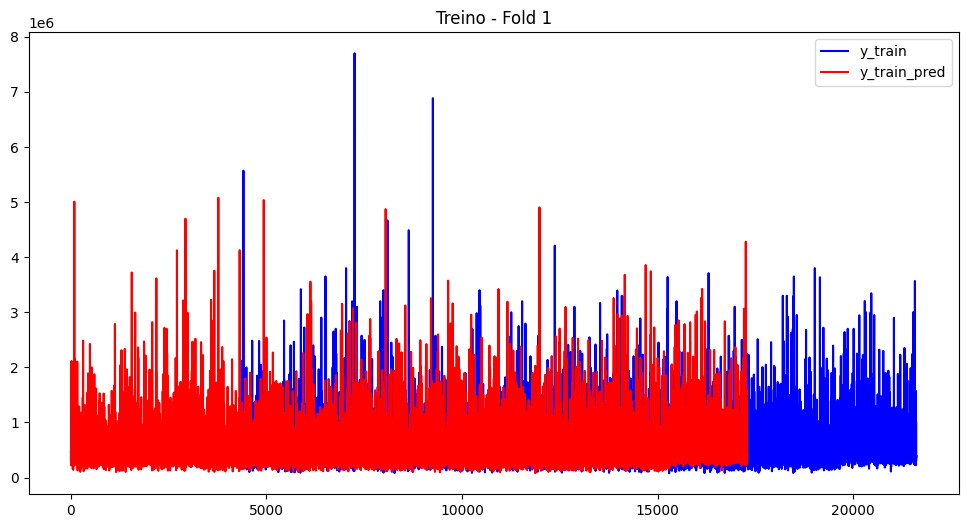

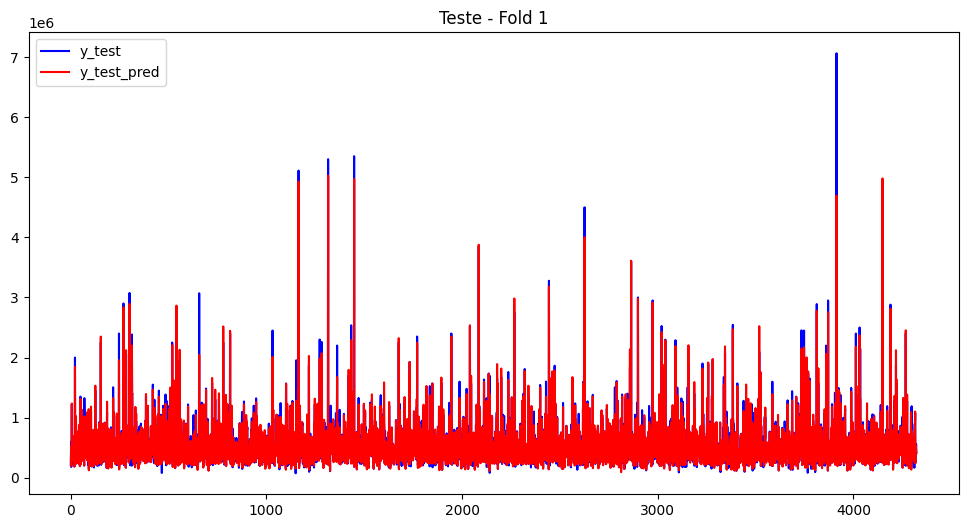

Cross_val_score no conjunto de treino para o Fold 2: [0.95577867 0.92864887 0.95658516 0.94824475 0.96012157]
Cross_val_score no conjunto de teste para o Fold 2: [0.9115117  0.92240932 0.91863867 0.86659189 0.9381764 ]



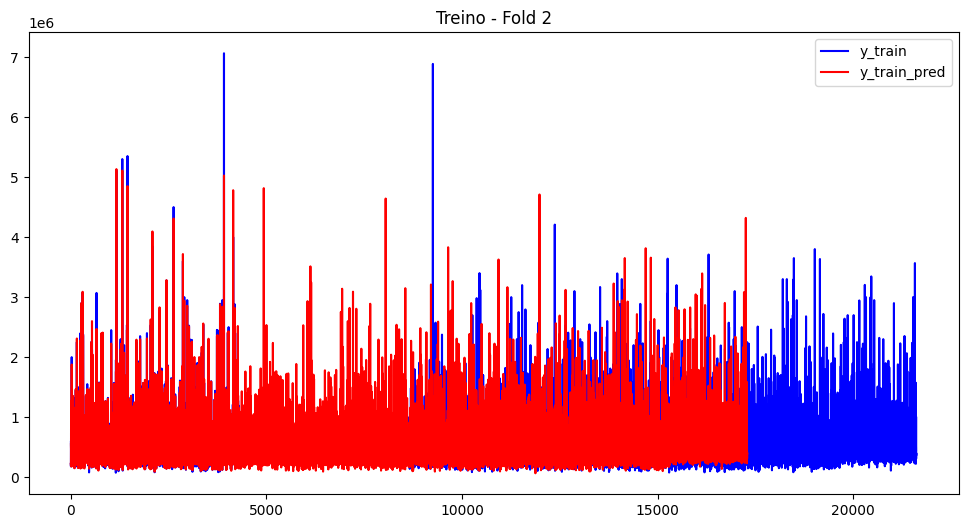

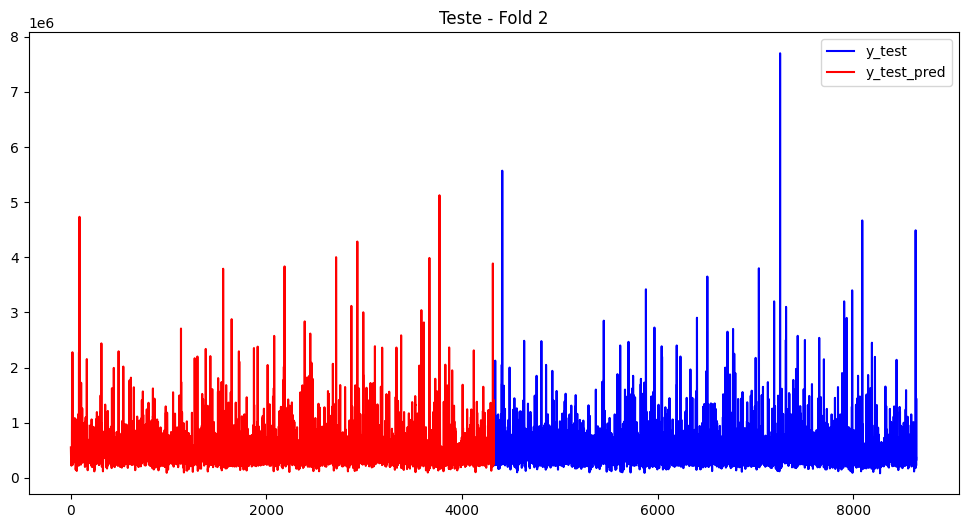

Cross_val_score no conjunto de treino para o Fold 3: [0.96096142 0.94571738 0.93919728 0.94765747 0.9622994 ]
Cross_val_score no conjunto de teste para o Fold 3: [0.81276998 0.90977468 0.92728353 0.93759711 0.9117226 ]



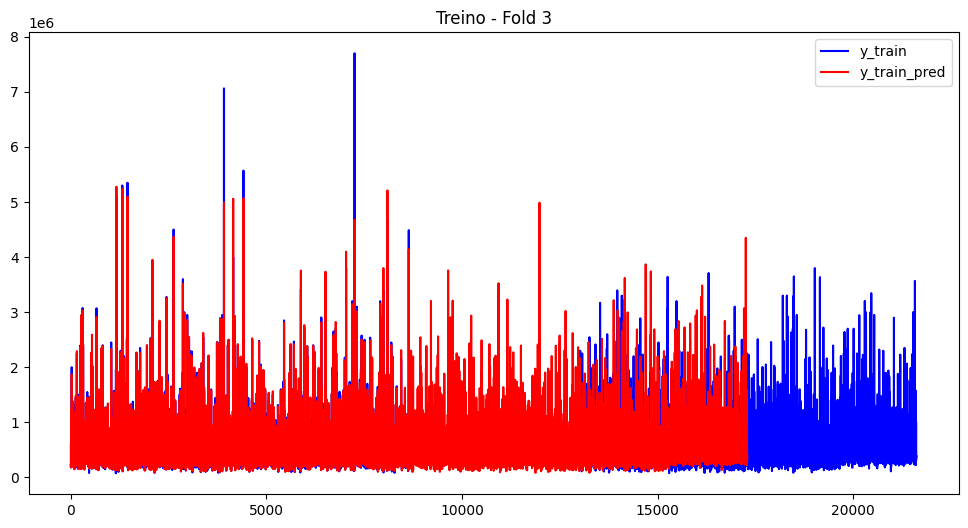

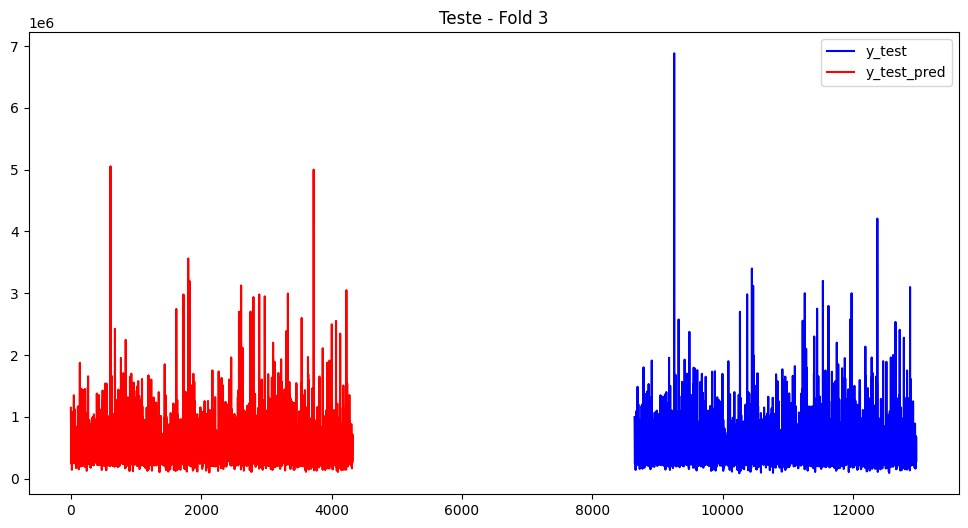

Cross_val_score no conjunto de treino para o Fold 4: [0.95826616 0.94587535 0.92667939 0.94883141 0.96096519]
Cross_val_score no conjunto de teste para o Fold 4: [0.93175539 0.93411953 0.92360058 0.91267105 0.92171592]



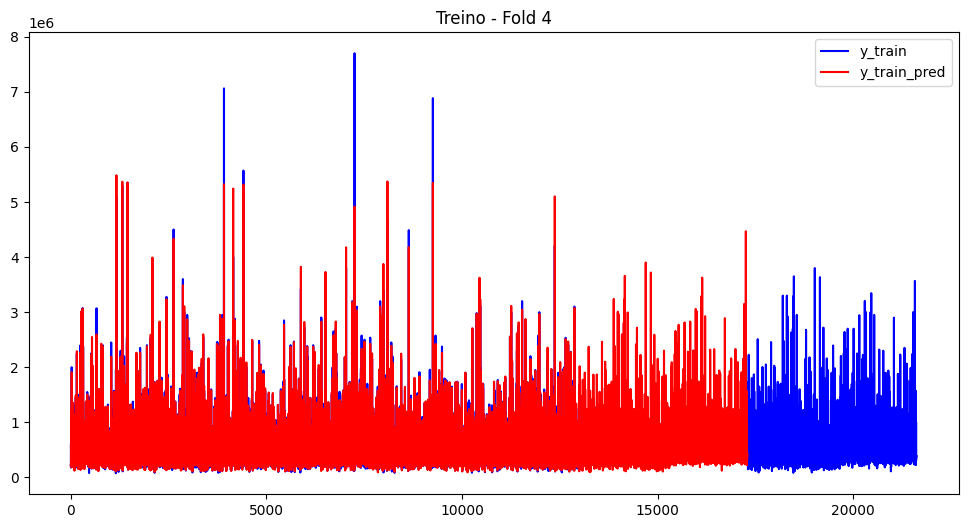

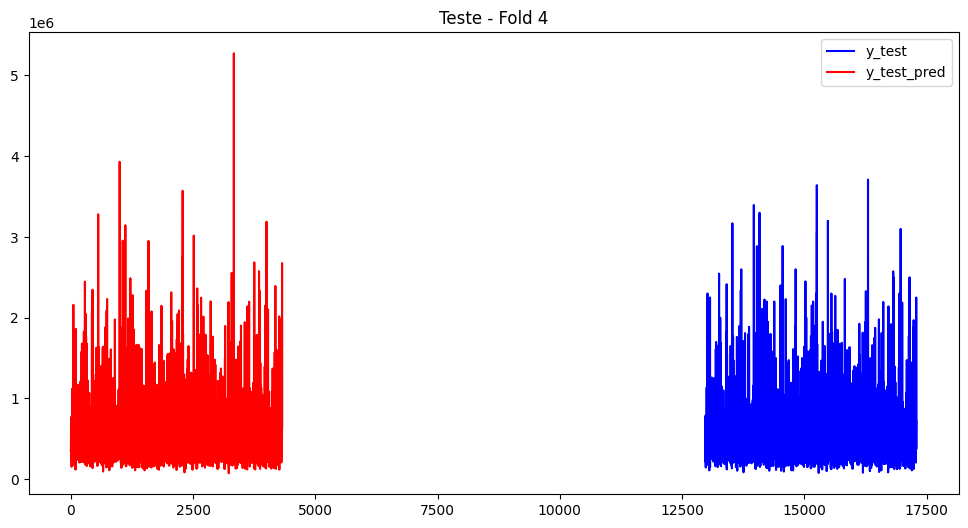

Cross_val_score no conjunto de treino para o Fold 5: [0.95961706 0.94432135 0.92600883 0.95388425 0.94698123]
Cross_val_score no conjunto de teste para o Fold 5: [0.90317837 0.93591046 0.92966238 0.96056156 0.96521739]



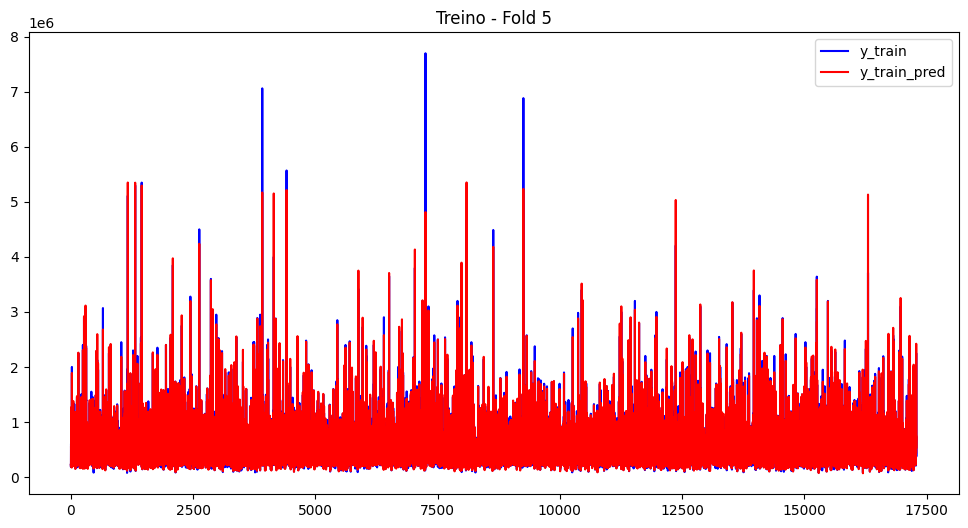

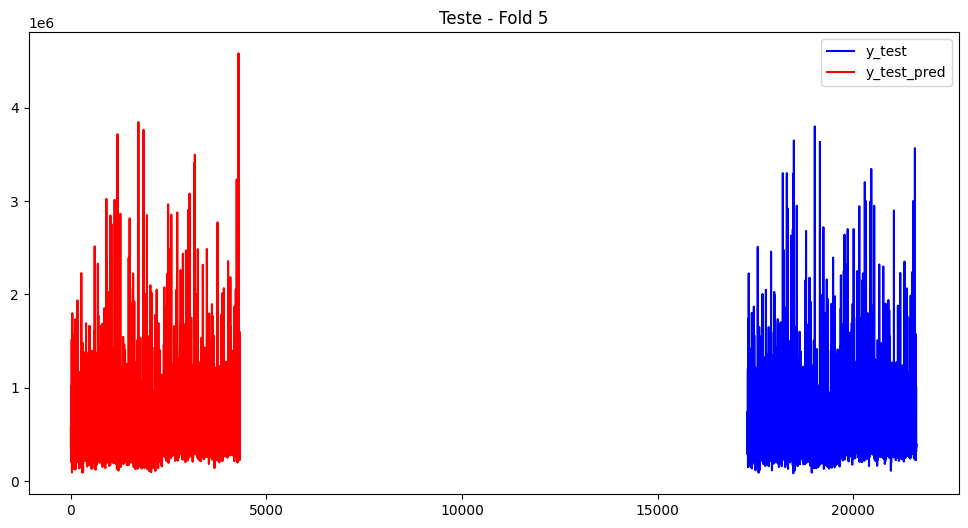

Média de R^2 no conjunto de treino: 0.9483533763520355
Média de R^2 no conjunto de teste: 0.9211892567419483


In [25]:
import matplotlib.pyplot as plt

kf = KFold(n_splits=5)

X = scaler.fit_transform(features.copy())
y = target.copy()

# Inicializando listas para armazenar pontuações
r2_train_scores = []
r2_test_scores = []

# Loop sobre cada fold
for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = XGBRegressor(colsample_bytree=1, gamma=0.0, learning_rate=0.01, max_depth=8, min_child_weight=8, n_estimators=7200, reg_alpha=1, reg_lambda=1, subsample=0.1, seed=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    train_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    print(f'Cross_val_score no conjunto de treino para o Fold {i}: {train_scores}')
    r2_train_scores.append(np.mean(train_scores))

    test_scores = cross_val_score(model, X_test, y_test, cv=kf, scoring='r2')
    print(f'Cross_val_score no conjunto de teste para o Fold {i}: {test_scores}\n')
    r2_test_scores.append(np.mean(test_scores))

    # Plotando os resultados
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, color='blue', label='y_train')
    plt.plot(y_train_pred, color='red', label='y_train_pred')
    plt.legend()
    plt.title(f'Treino - Fold {i}')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, color='blue', label='y_test')
    plt.plot(y_test_pred, color='red', label='y_test_pred')
    plt.legend()
    plt.title(f'Teste - Fold {i}')
    plt.show()

print(f'Média de R^2 no conjunto de treino: {np.mean(r2_train_scores)}')
print(f'Média de R^2 no conjunto de teste: {np.mean(r2_test_scores)}')


In [ ]:
# USANDO SELECTION FEATURES

X_train, X_test, y_train, y_test = train_test_split(features.copy(), target.copy(), test_size=0.30, random_state=50)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

sfm = SelectFromModel(model, threshold='mean', prefit=True)
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

model = XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=1.5, n_estimators=7200, reg_alpha=0.9, reg_lambda=0.6, subsample=0.2, seed=42)

# Treinar o modelo com as características selecionadas
model.fit(X_train_selected, y_train)

# Fazer previsões nos conjuntos de treino e teste
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

# Calcular R^2 nos conjuntos de treino e teste
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir resultados
print(f'R^2 no conjunto de teste: {r2_test}')
print(f'R^2 no conjunto de treino: {r2_train}')

R^2 no conjunto de teste: 0.7798893641340793
R^2 no conjunto de treino: 0.8167955787269656


In [ ]:
def create_model(data, target, algo, scaler=None):
	if scaler != None:
		X = scaler.fit_transform(data)
	else:
		X = data
	y = target
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=50)
	model = algo
	model.fit(X_train, y_train)
	return(model, X_train, X_test, y_train, y_test)

# Lista de modelos
modelos = [RandomForestRegressor(), LinearRegression(), GradientBoostingRegressor(), KNeighborsRegressor(), Lasso(), Ridge(), ElasticNet()]

for modelo in modelos:
    modelo, X_train, X_test, y_train, y_test = create_model(features.copy(), target.copy(), modelo, scaler=None)

    # Fazendo previsões
    y_pred = modelo.predict(X_test)
    y_pred_train = modelo.predict(X_train)

    # Calculando métricas
    mse = mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)

    # Imprimindo métricas
    print(f'Modelo: {modelo.__class__.__name__}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'R2 (Test) : {r2_test}')
    print(f'R2 (Training) : {r2_train}')
    print('-'*50)

Modelo: RandomForestRegressor
Mean Squared Error (MSE): 6495681751.39965
R2 (Test) : 0.9527956810717277
R2 (Training) : 0.9930295567268796
--------------------------------------------------
Modelo: LinearRegression
Mean Squared Error (MSE): 36826289585.955864
R2 (Test) : 0.732382221745115
R2 (Training) : 0.7268760838370316
--------------------------------------------------
Modelo: GradientBoostingRegressor
Mean Squared Error (MSE): 10277735822.839077
R2 (Test) : 0.9253113778954323
R2 (Training) : 0.936997852175775
--------------------------------------------------
Modelo: KNeighborsRegressor
Mean Squared Error (MSE): 63328739402.5464
R2 (Test) : 0.539788104391181
R2 (Training) : 0.7279908667999677
--------------------------------------------------
Modelo: Lasso
Mean Squared Error (MSE): 36826489878.07025
R2 (Test) : 0.732380766216164
R2 (Training) : 0.7268760803008455
--------------------------------------------------
Modelo: Ridge
Mean Squared Error (MSE): 36829703481.72212
R2 (Test) 

# A consistência dos modelos abaixo é evidenciada pela média e desvio padrão dos resultados obtidos abaixo, indicando que o desempenho permanece estável mesmo diante de variações (0.25 até 0.35) na divisão do conjunto em teste e treino.

In [ ]:
def create_model(data, target, algo, scaler=None, size=0.30):
	if scaler != None:
		X = scaler.fit_transform(data)
	else:
		X = data
	y = target
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=50)
	model = algo
	model.fit(X_train, y_train)
	return(model, X_train, X_test, y_train, y_test)

# Lista de modelos
modelos = [RandomForestRegressor(), LinearRegression(), GradientBoostingRegressor(), KNeighborsRegressor(), Lasso(), Ridge(), ElasticNet()]

resultados_diversos_regressores = []
for modelo in modelos:
    for s in np.arange(0.25, 0.36, 0.01):
      modelo, X_train, X_test, y_train, y_test = create_model(features.copy(), target.copy(), modelo, scaler=None, size=s)

      # Fazendo previsões
      y_pred = modelo.predict(X_test)
      y_pred_train = modelo.predict(X_train)

      # Calculando métricas
      #mse = mean_squared_error(y_test, y_pred)
      r2_test = r2_score(y_test, y_pred)
      r2_train = r2_score(y_train, y_pred_train)

      # Imprimindo métricas
      #print(f'Modelo: {modelo.__class__.__name__}')
      #print(f'Mean Squared Error (MSE): {mse}')
      #print(f'R2 (Test) : {r2_test}')
      #print(f'R2 (Training) : {r2_train}')
      #print('-'*50)
      resultados_diversos_regressores.append((modelo.__class__.__name__, s, r2_test, r2_train))

In [ ]:
# Criando um dicionário para armazenar os resultados por modelo
resultados_por_modelo = {}

# Iterando sobre as tuplas no vetor
for resultado in resultados_diversos_regressores:
    modelo_nome, s, r2_test, r2_train = resultado

    # Se o modelo ainda não está no dicionário, cria-se uma lista para ele
    if modelo_nome not in resultados_por_modelo:
        resultados_por_modelo[modelo_nome] = {'r2_test': [], 'r2_train': []}

    # Adicionando os valores à lista correspondente ao modelo
    resultados_por_modelo[modelo_nome]['r2_test'].append(r2_test)
    resultados_por_modelo[modelo_nome]['r2_train'].append(r2_train)

# Calculando média e desvio padrão para cada modelo
for modelo_nome, resultados in resultados_por_modelo.items():
    media_r2_test = np.mean(resultados['r2_test'])
    desvio_padrao_r2_test = np.std(resultados['r2_test'])

    media_r2_train = np.mean(resultados['r2_train'])
    desvio_padrao_r2_train = np.std(resultados['r2_train'])

    # Imprimindo os resultados
    print(f'Modelo: {modelo_nome}')
    print(f'Média de R^2 no conjunto de teste: {media_r2_test}, Desvio padrão: {desvio_padrao_r2_test}')
    print(f'Média de R^2 no conjunto de treino: {media_r2_train}, Desvio padrão: {desvio_padrao_r2_train}')
    print()

Modelo: RandomForestRegressor
Média de R^2 no conjunto de teste: 0.9526350219858465, Desvio padrão: 0.0009692710062697056
Média de R^2 no conjunto de treino: 0.9929032547923022, Desvio padrão: 0.000226581238837032

Modelo: LinearRegression
Média de R^2 no conjunto de teste: 0.7331488868258336, Desvio padrão: 0.001301815725384748
Média de R^2 no conjunto de treino: 0.7265537713189544, Desvio padrão: 0.0004276954409026875

Modelo: GradientBoostingRegressor
Média de R^2 no conjunto de teste: 0.9232968664072221, Desvio padrão: 0.0015401670598997224
Média de R^2 no conjunto de treino: 0.9357428987163569, Desvio padrão: 0.0010002779554385479

Modelo: KNeighborsRegressor
Média de R^2 no conjunto de teste: 0.5431219604720086, Desvio padrão: 0.002234589365972192
Média de R^2 no conjunto de treino: 0.7267884740749397, Desvio padrão: 0.003948537271199293

Modelo: Lasso
Média de R^2 no conjunto de teste: 0.7331473444742415, Desvio padrão: 0.0013013504563492684
Média de R^2 no conjunto de treino: 0